In [ ]:
## Install modules
!pip install praw
!python -m spacy download pt_core_news_lg

## Import modules
import os
from datetime import datetime
import spacy
nlp = spacy.load('pt_core_news_lg')
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import sys

if not os.path.exists('data'):
        os.mkdir('data')

In [ ]:
class MyCorpus:
    """
    A class that represents a corpus and has usefull methods defined.

    """
    
    def __init__(self, path, key='content'):
        """
        Reads from a JSON line file. Tokenizes and lemmatizes
        the text under key. It writes out the new JSON line
        file with a new field -- tokens.
        Args:
            path (str): a path to a JSON line.
            key (str): a key with the content to lemmatize.
        """
        self._path_original = path
        self._key = key
        self._dictionary = None
        self._path = path.replace('.', '_NLP.')
        with open(self._path, 'w') as file:
            n = 1
            for line in open(self._path_original, 'r'):
                temp_dict = json.loads(line)
                if temp_dict[self._key] == '[deleted]':
                    continue
                text_nlp = nlp(temp_dict[self._key])
                temp_dict['tokens'] = []
                for token in text_nlp:
                    is_stop = token.is_stop or token.is_punct or token.is_space \
                        or token.is_bracket or token.is_currency or token.is_digit \
                        or token.is_quote or token.like_url or token.like_email \
                        or len(token) < 2 or len(token) > 20 or (not token.lemma_.isalpha())
                    if is_stop:
                        continue
                    else:
                        temp_dict['tokens'].append(token.lemma_.lower())
                file.write( json.dumps(temp_dict) + '\n')
                sys.stdout.write(f'\rLine {n} processed')
                n += 1
                sys.stdout.flush()

        
    def set_dictionary(self, dictionary):
        """
        Assigns a gensim.corpora.dictionary.Dictioanry object
        to self._dictionary.

        Args:
            dictionary (gensim.corpora.dictionary.Dictionary): a dictionary
            that stores the frequencies of unique tokens in the corpus.
        """
        self._dictionary = dictionary

    def get_tokens(self):
        """
        It takes the path to a JSON line file with comments from Reddit and
        returns a generator that yields tokens for each comment.

        Yields:
            list : list of tokens for a comment from Reddit. 
        """
        for doc in open(self._path, 'r'):
            temp = json.loads(doc)
            yield temp['tokens']
    
    def get_bow(self):
        """
        It takes a dictionary with frequencies of unique tokens in the corpus
        and for each list of tokens returns a list of tuples that denote the 
        id of a given token and its frequency in a given document.

        Raises:
            ValueError: if the dictionary was not assigned to self._dictionary.

        Yields:
            list : a list of tuples that denote the id of a given token and its
            frequency in a given document.
        """
        if self._dictionary:
            for doc in self.get_tokens():
                yield self._dictionary.doc2bow(doc)
        else:
            raise ValueError('Dictionary has the value of None')
    
    def __iter__(self):
        """
        Yields:
            list : a list of tuples that denote the id of a given token and
            its frequency in a given document.
        """
        for doc in self.get_bow():
            yield doc

    def get_topics(self, model):
        """
        It takes a model and returns a generator that yields a mapping for each
        comment from Reddit. Among other keys it returns the most probable topic
        based on the LDA model provided and its probability.

        Args:
            model (gensim.models.ldamodel.LdaModel): Latent Dirchlet Allocation
            model.

        Yields:
            dict : a mapping for each comment from Reddit. Among other keys it
            returns the most prpobable topic based on the LDA model provided and
            its probability. 
        """
        for doc in open(self._path, 'r'):
            temp = json.loads(doc)
            topics = model.get_document_topics(self._dictionary.doc2bow(temp['tokens']))
            topic, prob = sorted( topics, key = lambda x: x[1], reverse=True )[0]
            temp['topic'] = topic + 1
            temp['topic_prob'] = prob
            yield temp

                
class MyModel(LdaModel):
    """
    Subclass of gensim.models.LdaModel.
    """
    def get_coherence(self, corpus):
        """
        Returns the average coherence measure for the given model.

        Args:
            corpus (MyCorpus): A corpus on which the model is computed. 

        Returns:
            float: the average coherence measure for the given model.
        """
        top_topics = self.top_topics(corpus)
        return sum([t[1] for t in top_topics]) / len(top_topics)
    
    def get_top_tokens(self, corpus):
        """
        Returns a list of dictionaries that depict the most probable
        tokens for each topic.

        Args:
            corpus (MyCorpus): A corpus on which the model was computed.

        Returns:
            list: list of dicitionaries that depict the most probable 
            tokens fro each topic.
        """
        top_tokens = self.top_topics(corpus)
        return [ { key : value for value, key in t[0] } for t in top_tokens ]

    
    
        
def run_lda_models(corpus, dictionary, min_topics, max_topics, step = 1, **kwargs):
    """
    Computes a sequence of lda models for a given corpus and dictionary. It prints
    the coherence measure and number of topics to the screen. It writes out the
    model to disk.

    Args:
        corpus (MyModel): A stream of document vectors or sparse matrix of shape (num_documents, num_terms).
        dictionary (dict): a mapping that assigns id to unique tokens from the corpus.
        min_topics (int): the smallest number of topics to compute.
        max_topics (int): the highest number of topics to compute.
        step (int, optional): the size of the break inbetween computed models. Defaults to 1.
    """
    name = input("Please provide the name of the model\n")
    temp = dictionary[0]
    id2word = dictionary.id2token
    if not os.path.exists('models'):
        os.mkdir('models')
    if not os.path.exists('png'):
        os.mkdir('png')
    for num_topic in range(min_topics, max_topics+1, step):
        model = MyModel( corpus = corpus,
                         id2word=id2word,
                         alpha = 'asymmetric',
                         eta = 'auto',
                         iterations = 500,
                         passes = 20,
                         eval_every=None,
                         num_topics=num_topic,
                         random_state=1044,
                         per_word_topics=True)
        temp_dict = {}
        temp_dict['name'] = name
        temp_dict['num_topics'] =  num_topic
        temp_dict['coherence'] = model.get_coherence(corpus = corpus)
        path_name = os.path.join('models', name + '-' + str(num_topic))
        model.save(path_name) 
        print(temp_dict)

## BEFORE YOU RUN the below

Please make sure that you upload the files I sent you to the Google Colab. You need to press the folder icon on the left-hand side and press upload. Afterwards, please drag the file you uploaded to the data folder.

In [ ]:
## Read corpus
corpus = MyCorpus(path = 'data/comments_portugal_veg.jl', key = 'body')

Line 355 processed

In [ ]:
## Create the dictionary
dictionary = Dictionary( corpus.get_tokens() )

In [ ]:
dictionary.filter_extremes(no_below=.9, no_above=.1)

In [ ]:
## Add the dictionary to the corpus
corpus.set_dictionary(dictionary)

In [ ]:
## Compute modesl and write them out to the files
run_lda_models(corpus = corpus, dictionary = dictionary, min_topics=2, max_topics=10)

{'name': 'portugal-veg', 'num_topics': 2, 'coherence': -3.9032501835316014}
{'name': 'portugal-veg', 'num_topics': 3, 'coherence': -3.976499866110528}
{'name': 'portugal-veg', 'num_topics': 4, 'coherence': -5.7535967661548435}
{'name': 'portugal-veg', 'num_topics': 5, 'coherence': -8.767456872167411}
{'name': 'portugal-veg', 'num_topics': 6, 'coherence': -7.663859998750342}
{'name': 'portugal-veg', 'num_topics': 7, 'coherence': -8.376527353333652}
{'name': 'portugal-veg', 'num_topics': 8, 'coherence': -8.28516177975402}
{'name': 'portugal-veg', 'num_topics': 9, 'coherence': -9.515637970048411}
{'name': 'portugal-veg', 'num_topics': 10, 'coherence': -8.53410838620736}


In [ ]:
## Read in the module. It requires providing
## the name of the model we want to load.
model_name = input('Provide the name of the model you would like to load:\r')
model_path = os.path.join('models', model_name)
model = LdaModel.load(model_path)

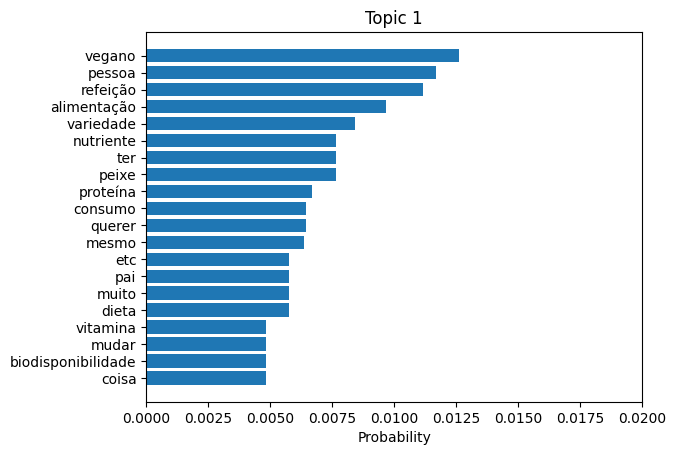

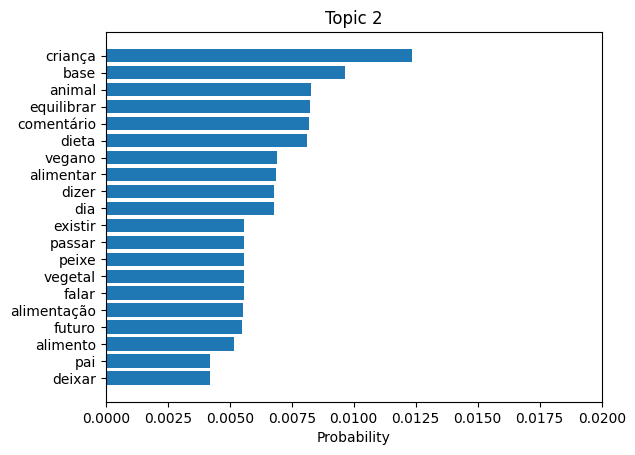

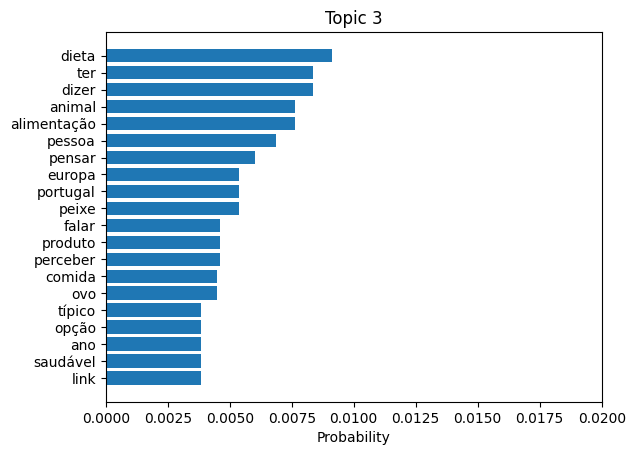

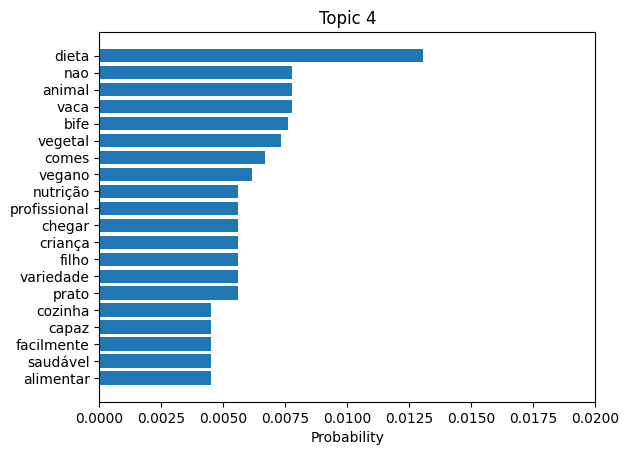

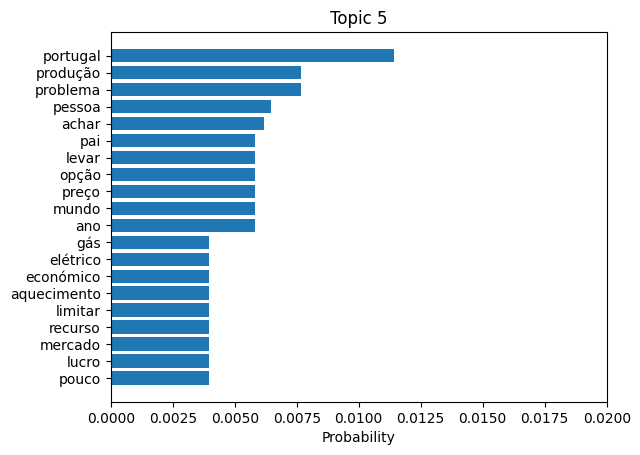

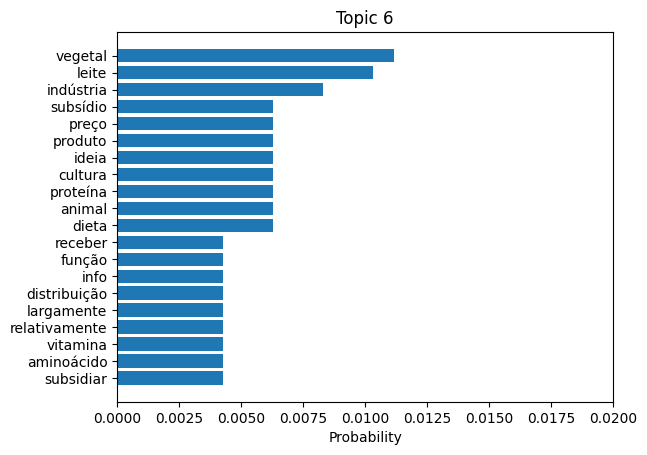

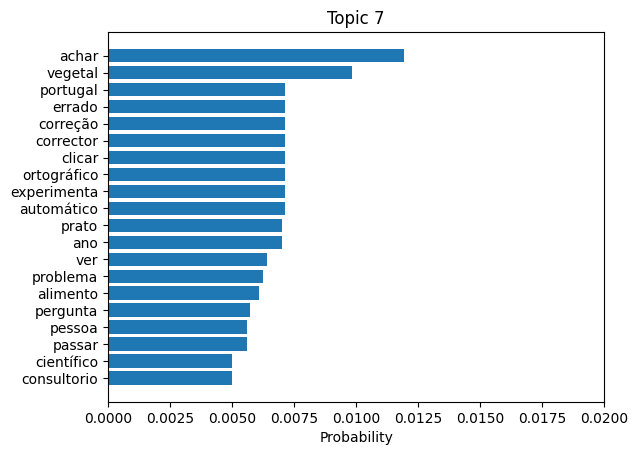

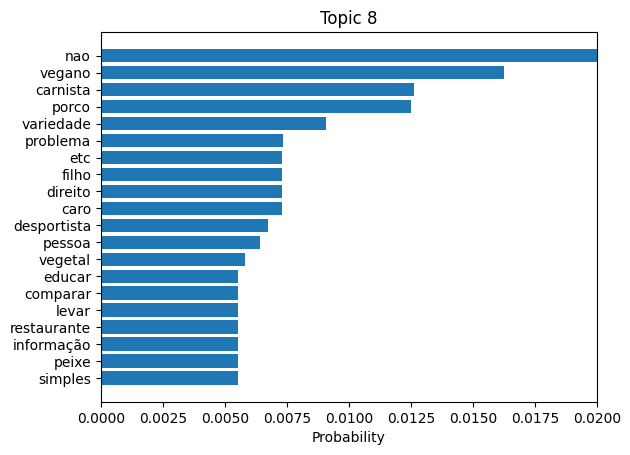

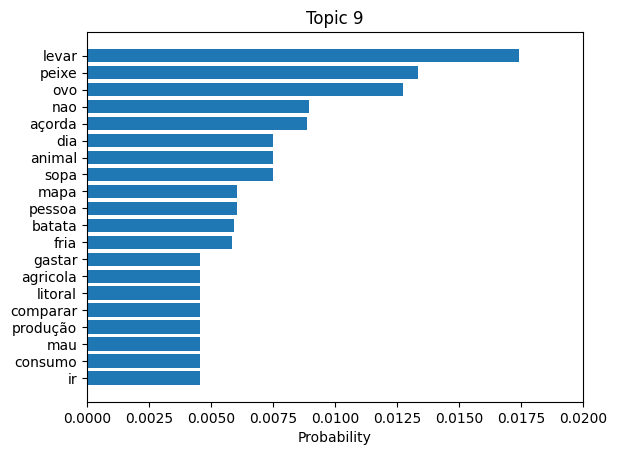

In [ ]:
## Print out and write the figures with the most 
## probable tokens in each topic.
list_top_tokens = model.get_top_tokens(corpus)
for i in range(len(list_top_tokens)):
    plt.barh(list(list_top_tokens[i].keys()), list(list_top_tokens[i].values()), align = 'center')
    plt.xlim(0,.02)
    plt.gca().invert_yaxis()
    plt.title('Topic' + ' ' + str(i + 1))
    plt.xlabel('Probability')
    plt.savefig('png/' + 'topic' + str(i + 1))
    plt.show()